## <span style="color:#db7d60">Setup</span>

In [1]:
! pip install patchworklib -q

%load_ext autoreload
%autoreload 2

import json
import math
import pickle
import numpy as np
import pandas as pd
import textwrap
import sys
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import patchworklib as pw

# pUtil needs to be loaded from the root directory
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

import pUtil
from analysis_common import *
import data_manager
import analysis as anal

import vector
from particle import Particle
from particle import PDGID

plt.rcParams['figure.figsize'] = (21, 6)
# plt.ioff()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

DEPRECATION: Loading egg at /global/common/software/nersc9/pytorch/2.3.1/lib/python3.11/site-packages/torchvision-0.18.0a0+6043bc2-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


<Figure size 100x100 with 0 Axes>

## <span style="color:#db7d60">Analysis</span>

(<Figure size 6300x1800 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Loss'>)

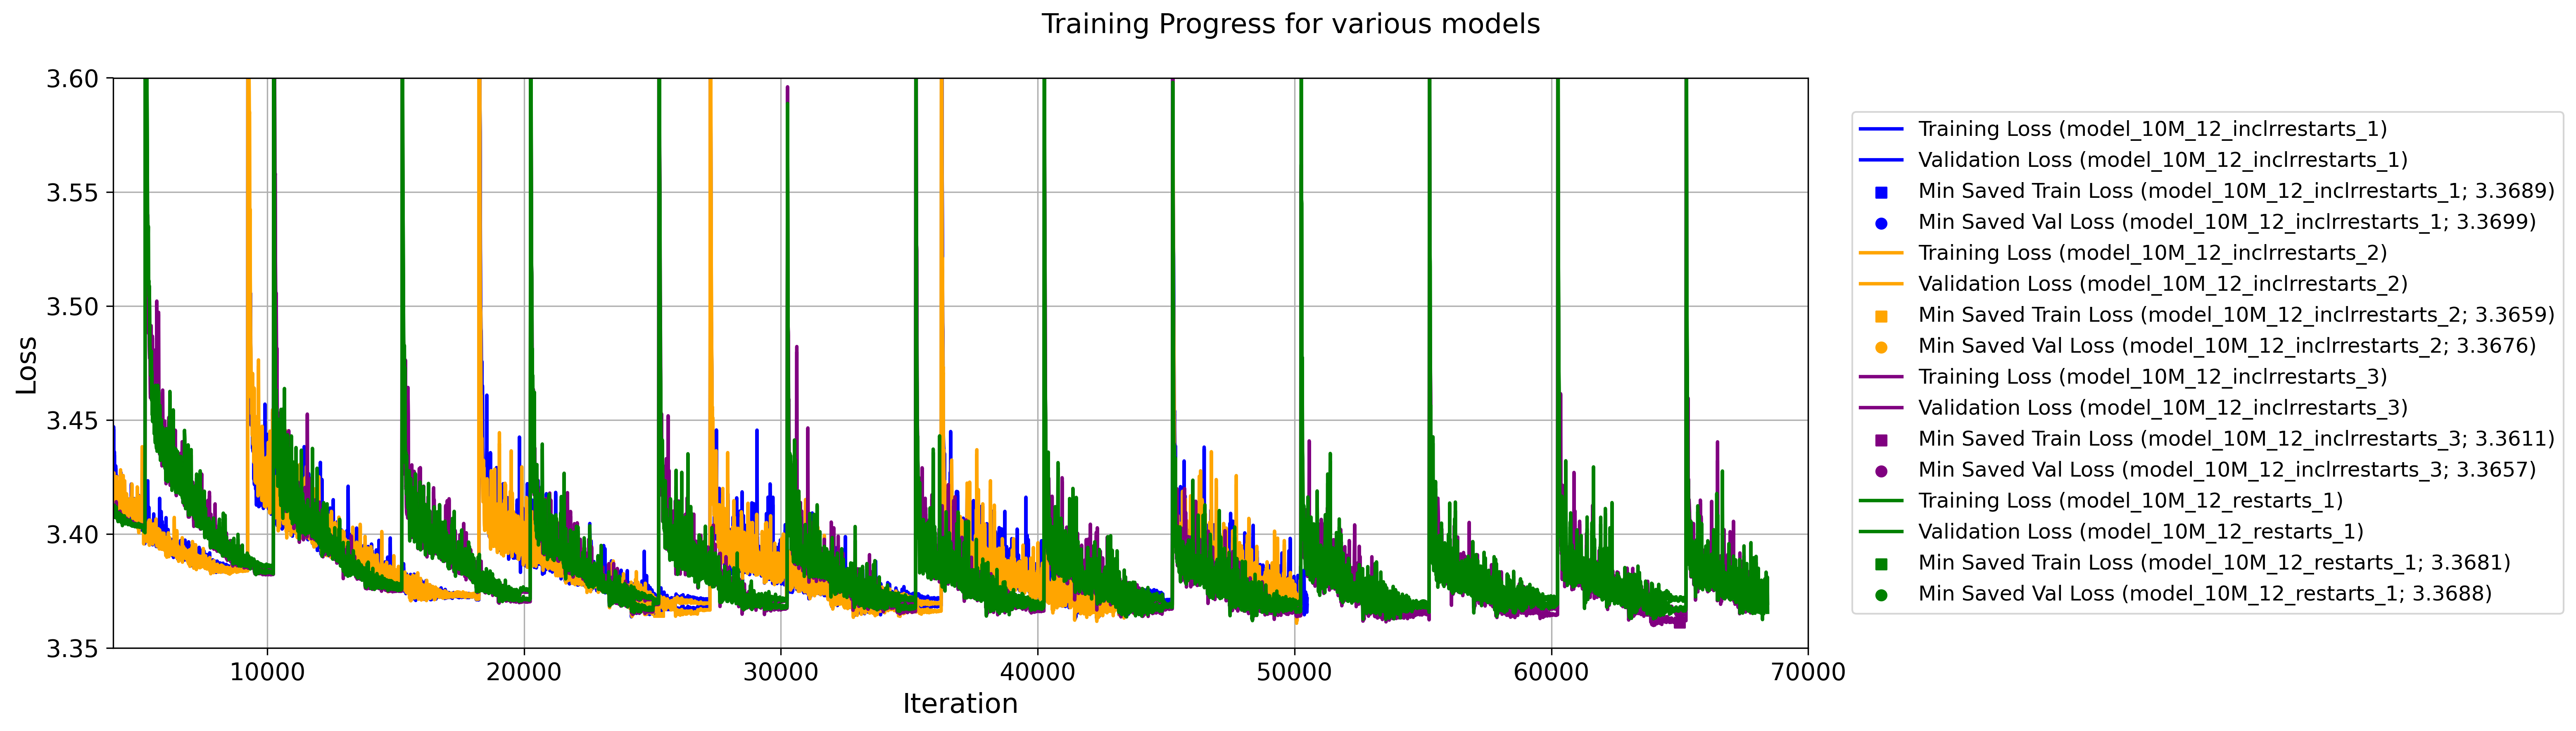

In [16]:
anal.plotting.plot_training_run(['model_10M_12_inclrrestarts_1', 'model_10M_12_inclrrestarts_2', 'model_10M_12_inclrrestarts_3', 'model_10M_12_restarts_1'], use_log=False, y_lim=(3.35, 3.6), x_lim=(4000, 70000))

(<Figure size 6300x1800 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Loss'>)

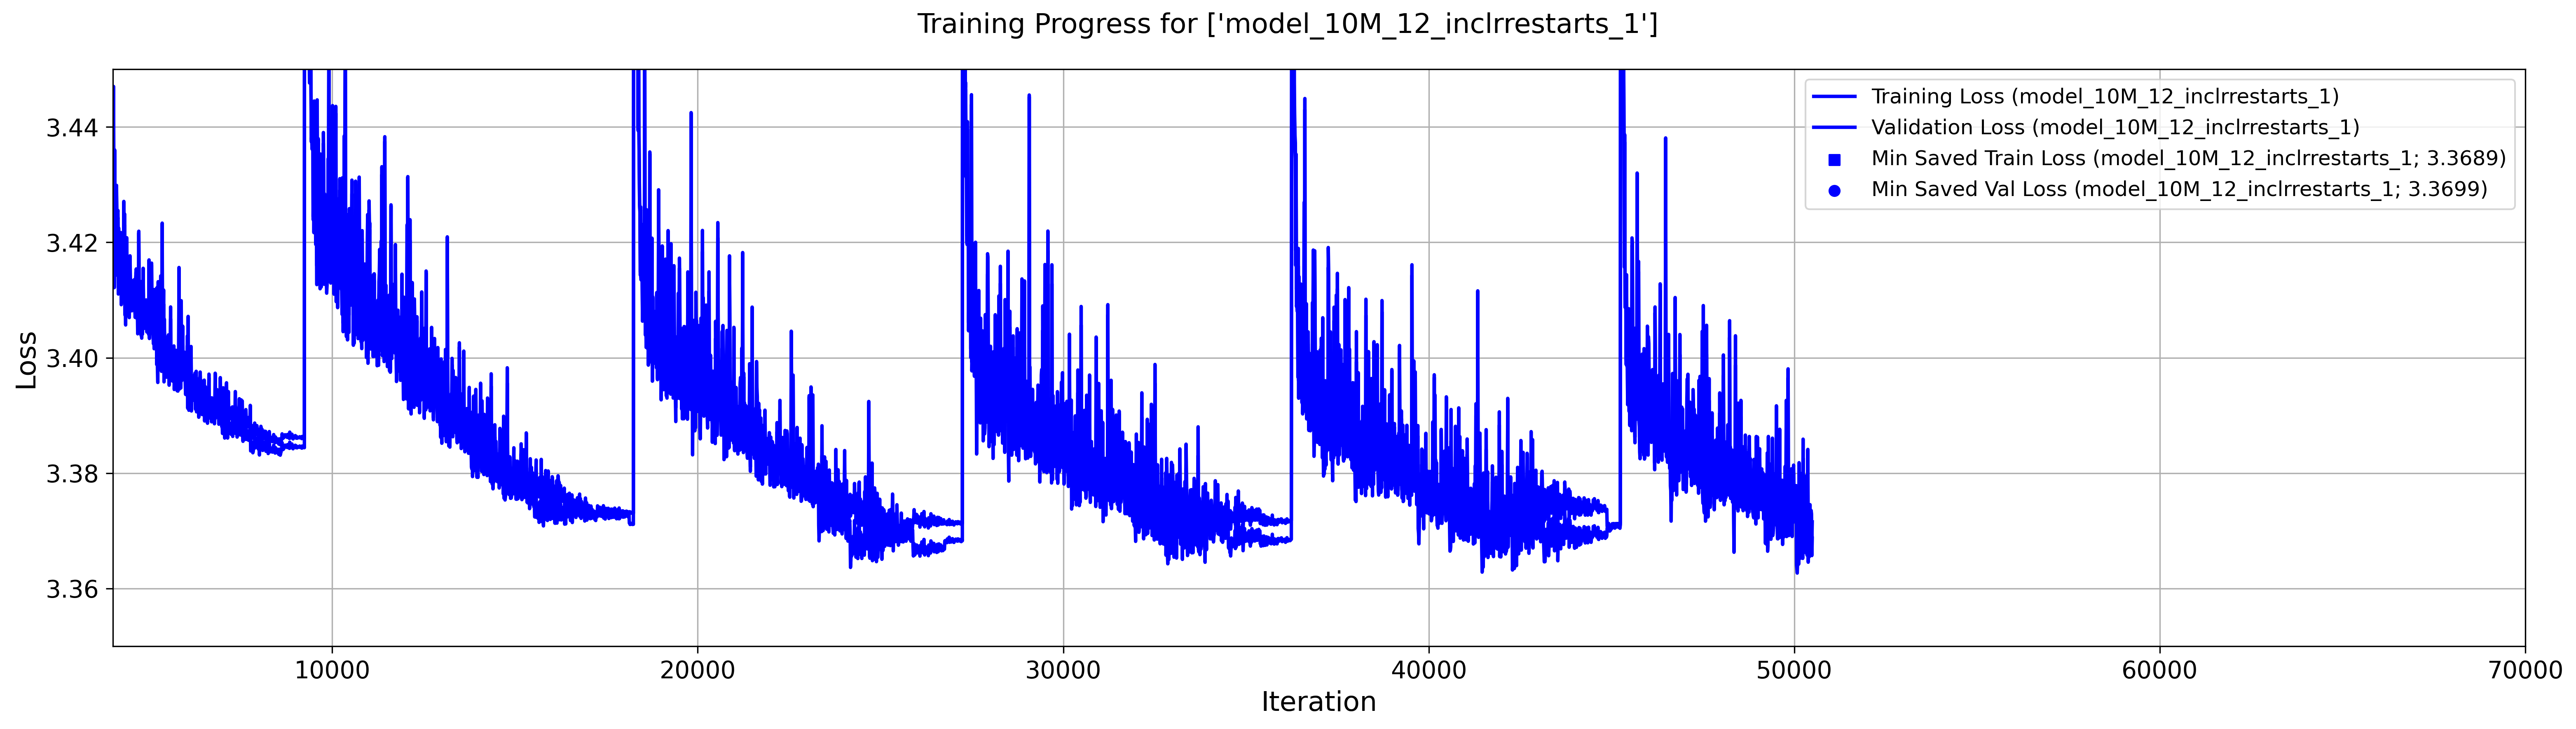

In [17]:
anal.plotting.plot_training_run(['model_10M_12_inclrrestarts_1'], use_log=False, y_lim=(3.35, 3.45), x_lim=(4000, 70000))

(<Figure size 6300x1800 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Loss'>)

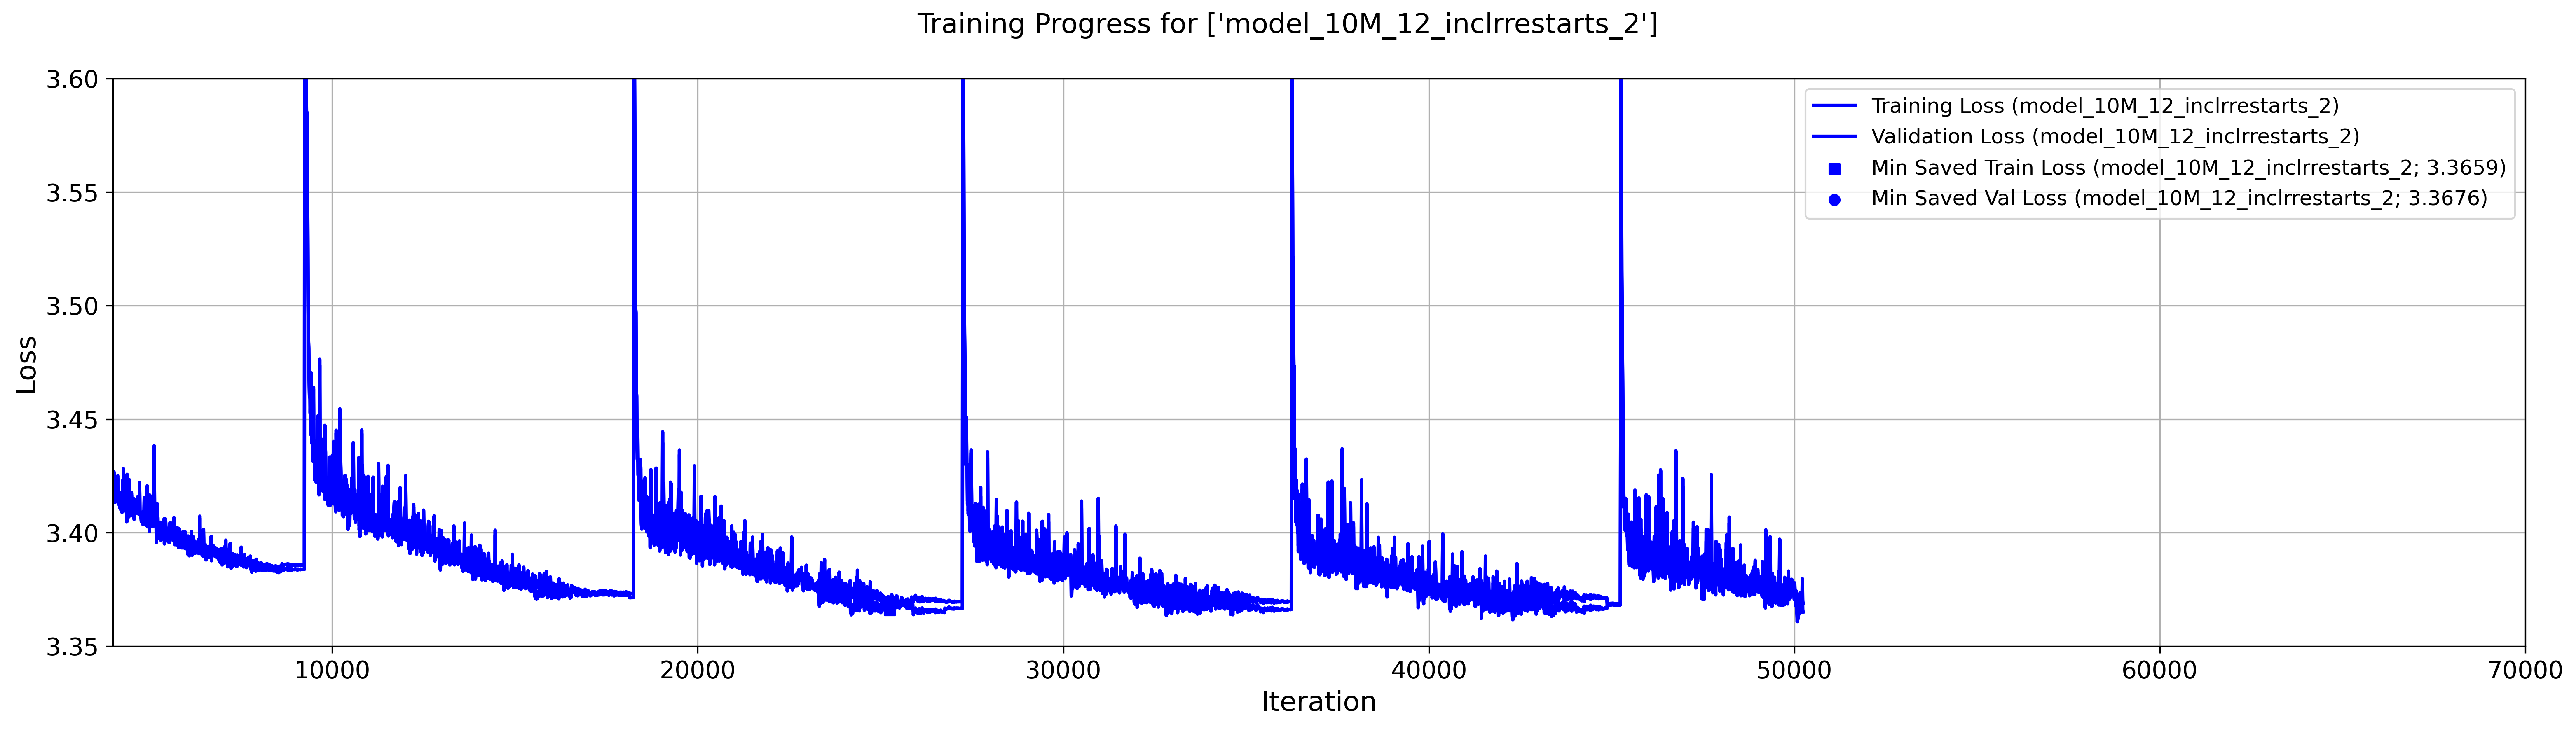

In [18]:
anal.plotting.plot_training_run(['model_10M_12_inclrrestarts_2'], use_log=False, y_lim=(3.35, 3.6), x_lim=(4000, 70000))

(<Figure size 6300x1800 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Loss'>)

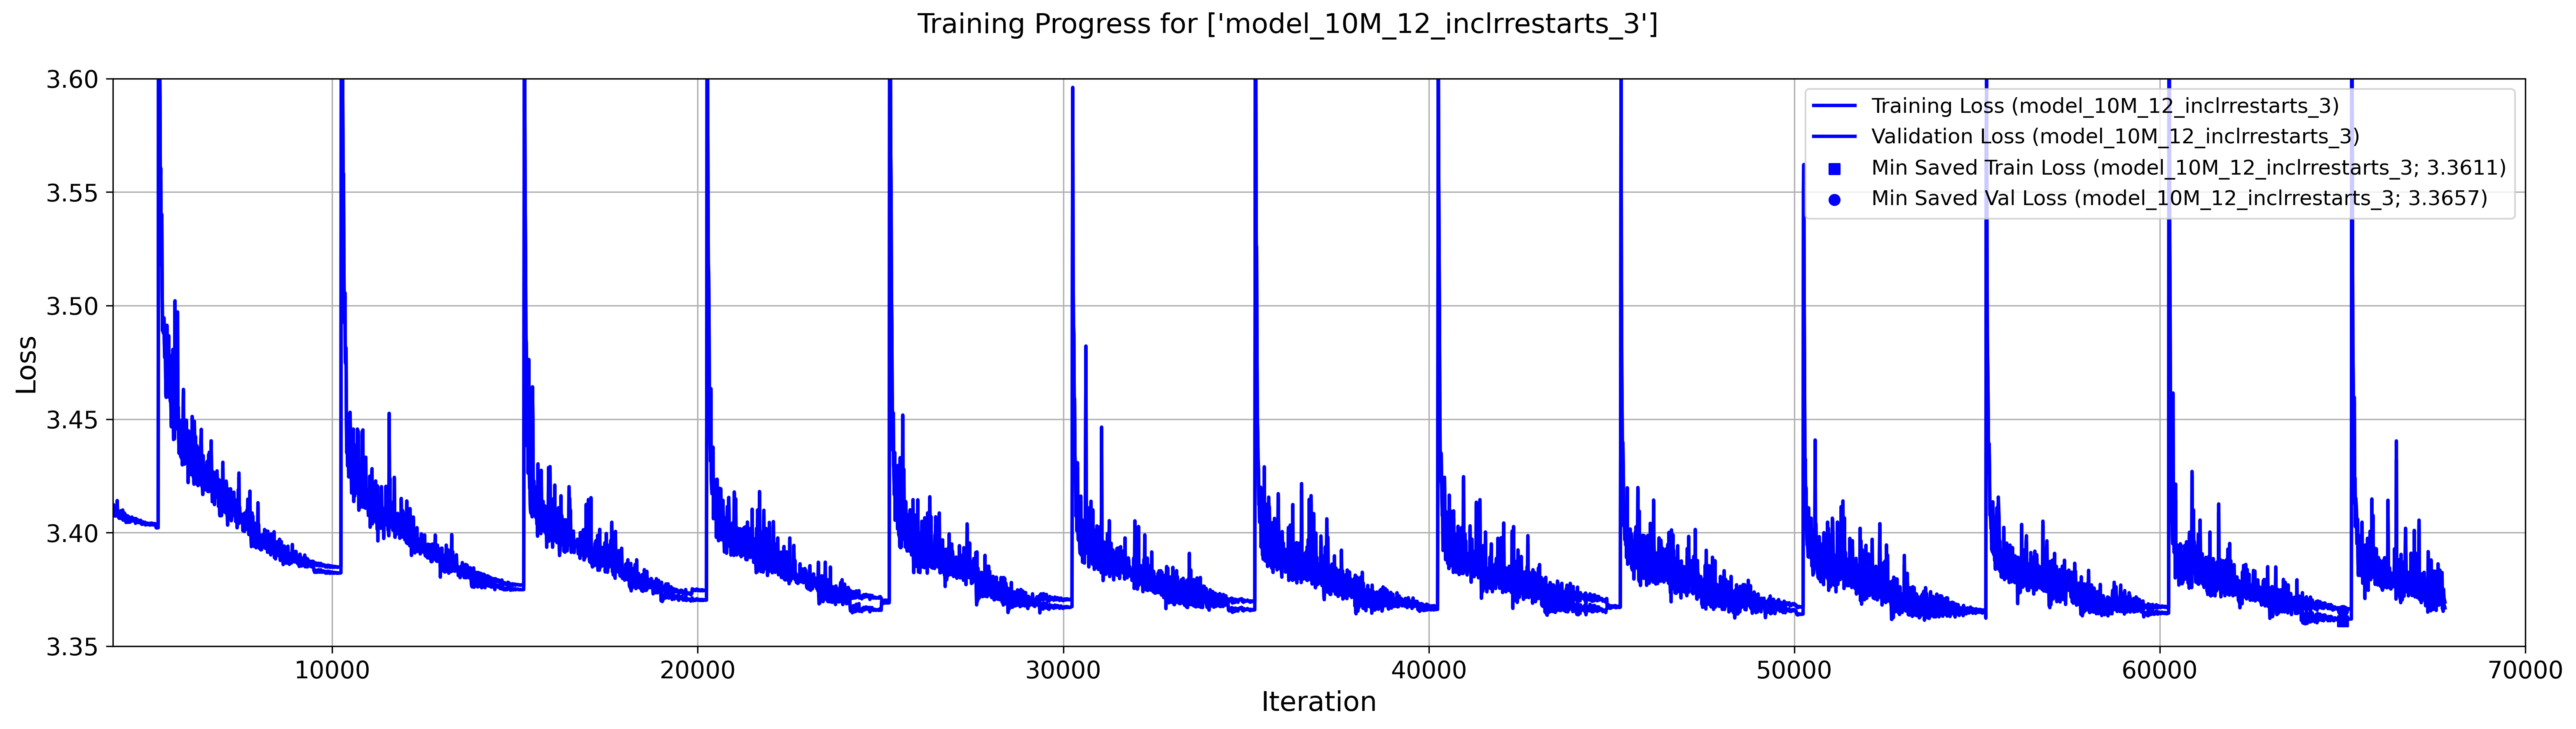

In [19]:
anal.plotting.plot_training_run(['model_10M_12_inclrrestarts_3'], use_log=False, y_lim=(3.35, 3.6), x_lim=(4000, 70000))

(<Figure size 6300x1800 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Loss'>)

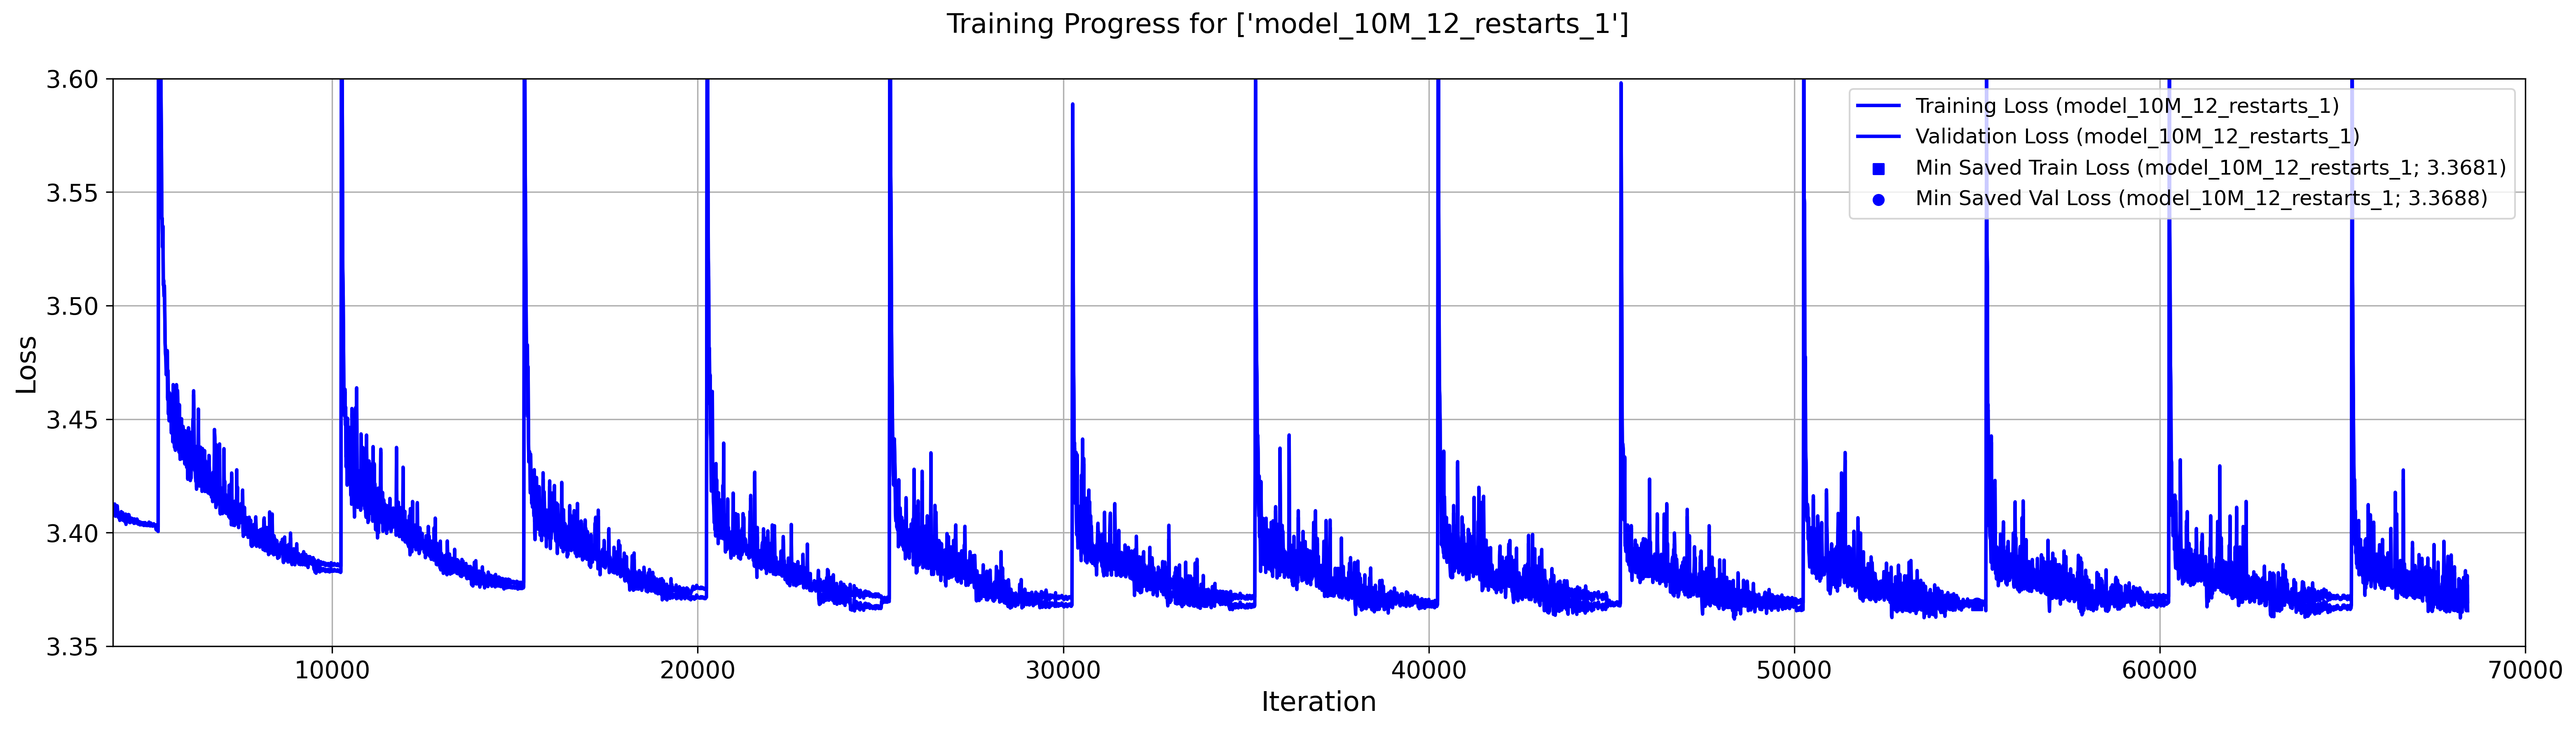

In [20]:
anal.plotting.plot_training_run(['model_10M_12_restarts_1'], use_log=False, y_lim=(3.35, 3.6), x_lim=(4000, 70000))

In [21]:
df = anal.tables.get_default_df([
    'model_10M_12_inclrrestarts_1',
    'model_10M_12_inclrrestarts_2',
    'model_10M_12_inclrrestarts_3',
    'model_10M_12_restarts_1',
])

display(df[['model_name', 'iters_trained', 'min_saved_train_loss', 'min_saved_val_loss'] + anal.tables.model_config_columns])
display(df[['model_name', 'iters_trained', 'min_saved_train_loss', 'min_saved_val_loss'] + anal.tables.model_config_columns].sort_values(by='min_saved_val_loss', ascending=True))

model_name  iters_trained  min_saved_train_loss  min_saved_val_loss  batch_size  block_size  learning_rate        min_lr  lr_decay_iters                         lr_scheduler  n_layer  n_head  n_embd   scheme preparation_name
0  model_10M_12_inclrrestarts_1          50490              3.368880            3.369894         128         NaN          0.001  1.000000e-06            9000  cosine_annealing_with_warm_restarts        4       2     512  unknown          unknown
1  model_10M_12_inclrrestarts_2          50240              3.365918            3.367612         128         NaN          0.001  1.000000e-07            9000  cosine_annealing_with_warm_restarts        4       2     512  unknown          unknown
2  model_10M_12_inclrrestarts_3          67800              3.361139            3.365685         128         NaN          0.001  1.000000e-07            5000  cosine_annealing_with_warm_restarts        4       2     512  unknown          unknown
3       model_10M_12_restarts_1          68420              3.368072            3.368830         128         NaN          0.001  1.000000e-05            5000  cosine_annealing_with_warm_restarts        4       2     512  unknown          unknown

model_name  iters_trained  min_saved_train_loss  min_saved_val_loss  batch_size  block_size  learning_rate        min_lr  lr_decay_iters                         lr_scheduler  n_layer  n_head  n_embd   scheme preparation_name
2  model_10M_12_inclrrestarts_3          67800              3.361139            3.365685         128         NaN          0.001  1.000000e-07            5000  cosine_annealing_with_warm_restarts        4       2     512  unknown          unknown
1  model_10M_12_inclrrestarts_2          50240              3.365918            3.367612         128         NaN          0.001  1.000000e-07            9000  cosine_annealing_with_warm_restarts        4       2     512  unknown          unknown
3       model_10M_12_restarts_1          68420              3.368072            3.368830         128         NaN          0.001  1.000000e-05            5000  cosine_annealing_with_warm_restarts        4       2     512  unknown          unknown
0  model_10M_12_inclrrestarts_1          50490              3.368880            3.369894         128         NaN          0.001  1.000000e-06            9000  cosine_annealing_with_warm_restarts        4       2     512  unknown          unknown

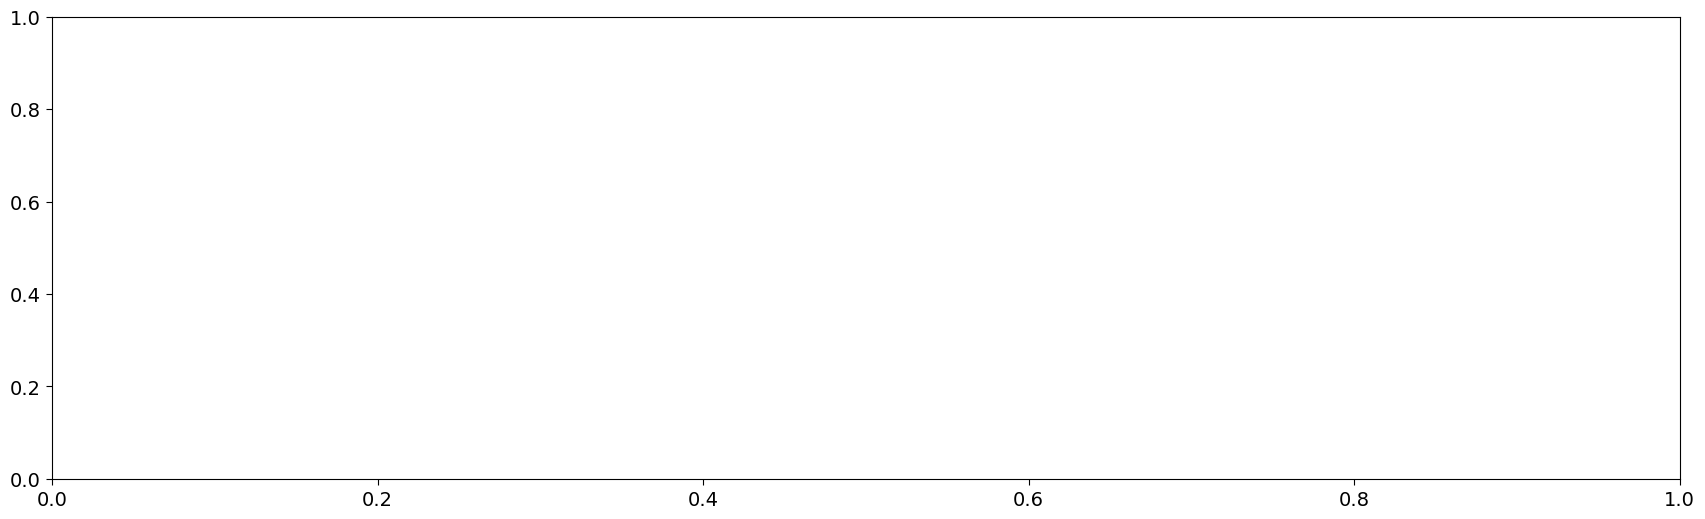

In [22]:
all_columns = ["e", "px", "py", "pz", "pt", "eta", "theta", "phi"]

models_to_compare = ['model_10M_12_inclrrestarts_1', 'model_10M_12_inclrrestarts_2', 'model_10M_12_inclrrestarts_3', 'model_10M_12_restarts_1']

plotter = anal.plotting()
plotter.load_data_by_model_names(models_to_compare)

all_particles_bricks = []
leading_particles_bricks = []
for column in all_columns:
    brick_all = pw.Brick(f'all_{column}', figsize=(8, 6))
    plotter.compare_distributions_all(models_to_compare, column_name=column, normalized=False, use_log=False, auto_show=False, in_ax=brick_all)
    all_particles_bricks.append(brick_all)

    brick_leading = pw.Brick(f'leading_{column}', figsize=(8, 6))
    plotter.compare_distributions_leading(models_to_compare, column_name=column, normalized=False, use_log=False, auto_show=False, in_ax=brick_leading)
    leading_particles_bricks.append(brick_leading)

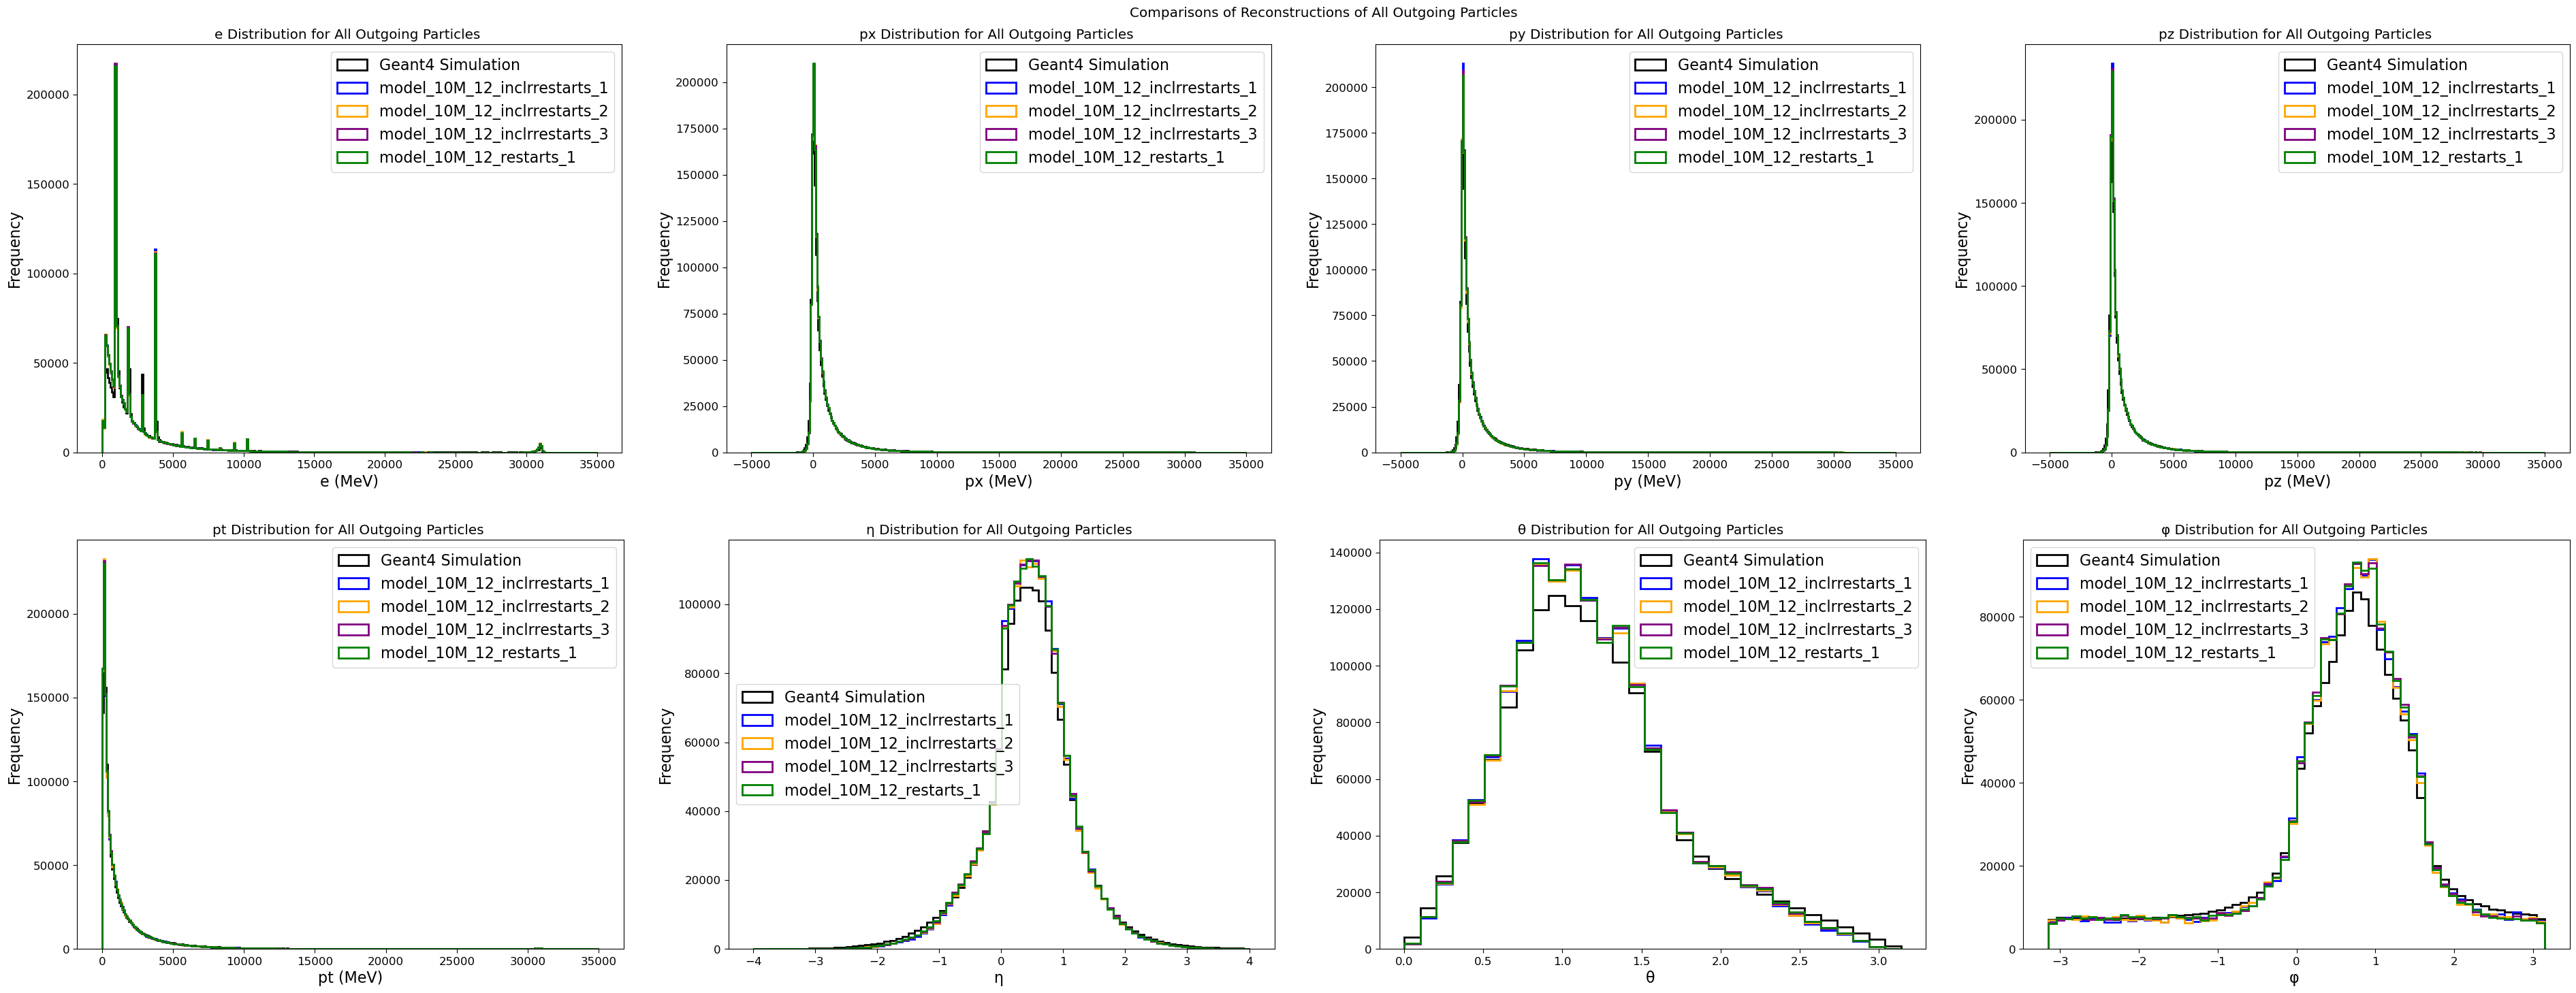

In [23]:
wall = (all_particles_bricks[0] | all_particles_bricks[1] | all_particles_bricks[2] | all_particles_bricks[3]) / (all_particles_bricks[4] | all_particles_bricks[5] | all_particles_bricks[6] | all_particles_bricks[7])
wall.set_suptitle('Comparisons of Reconstructions of All Outgoing Particles')
wall.savefig()

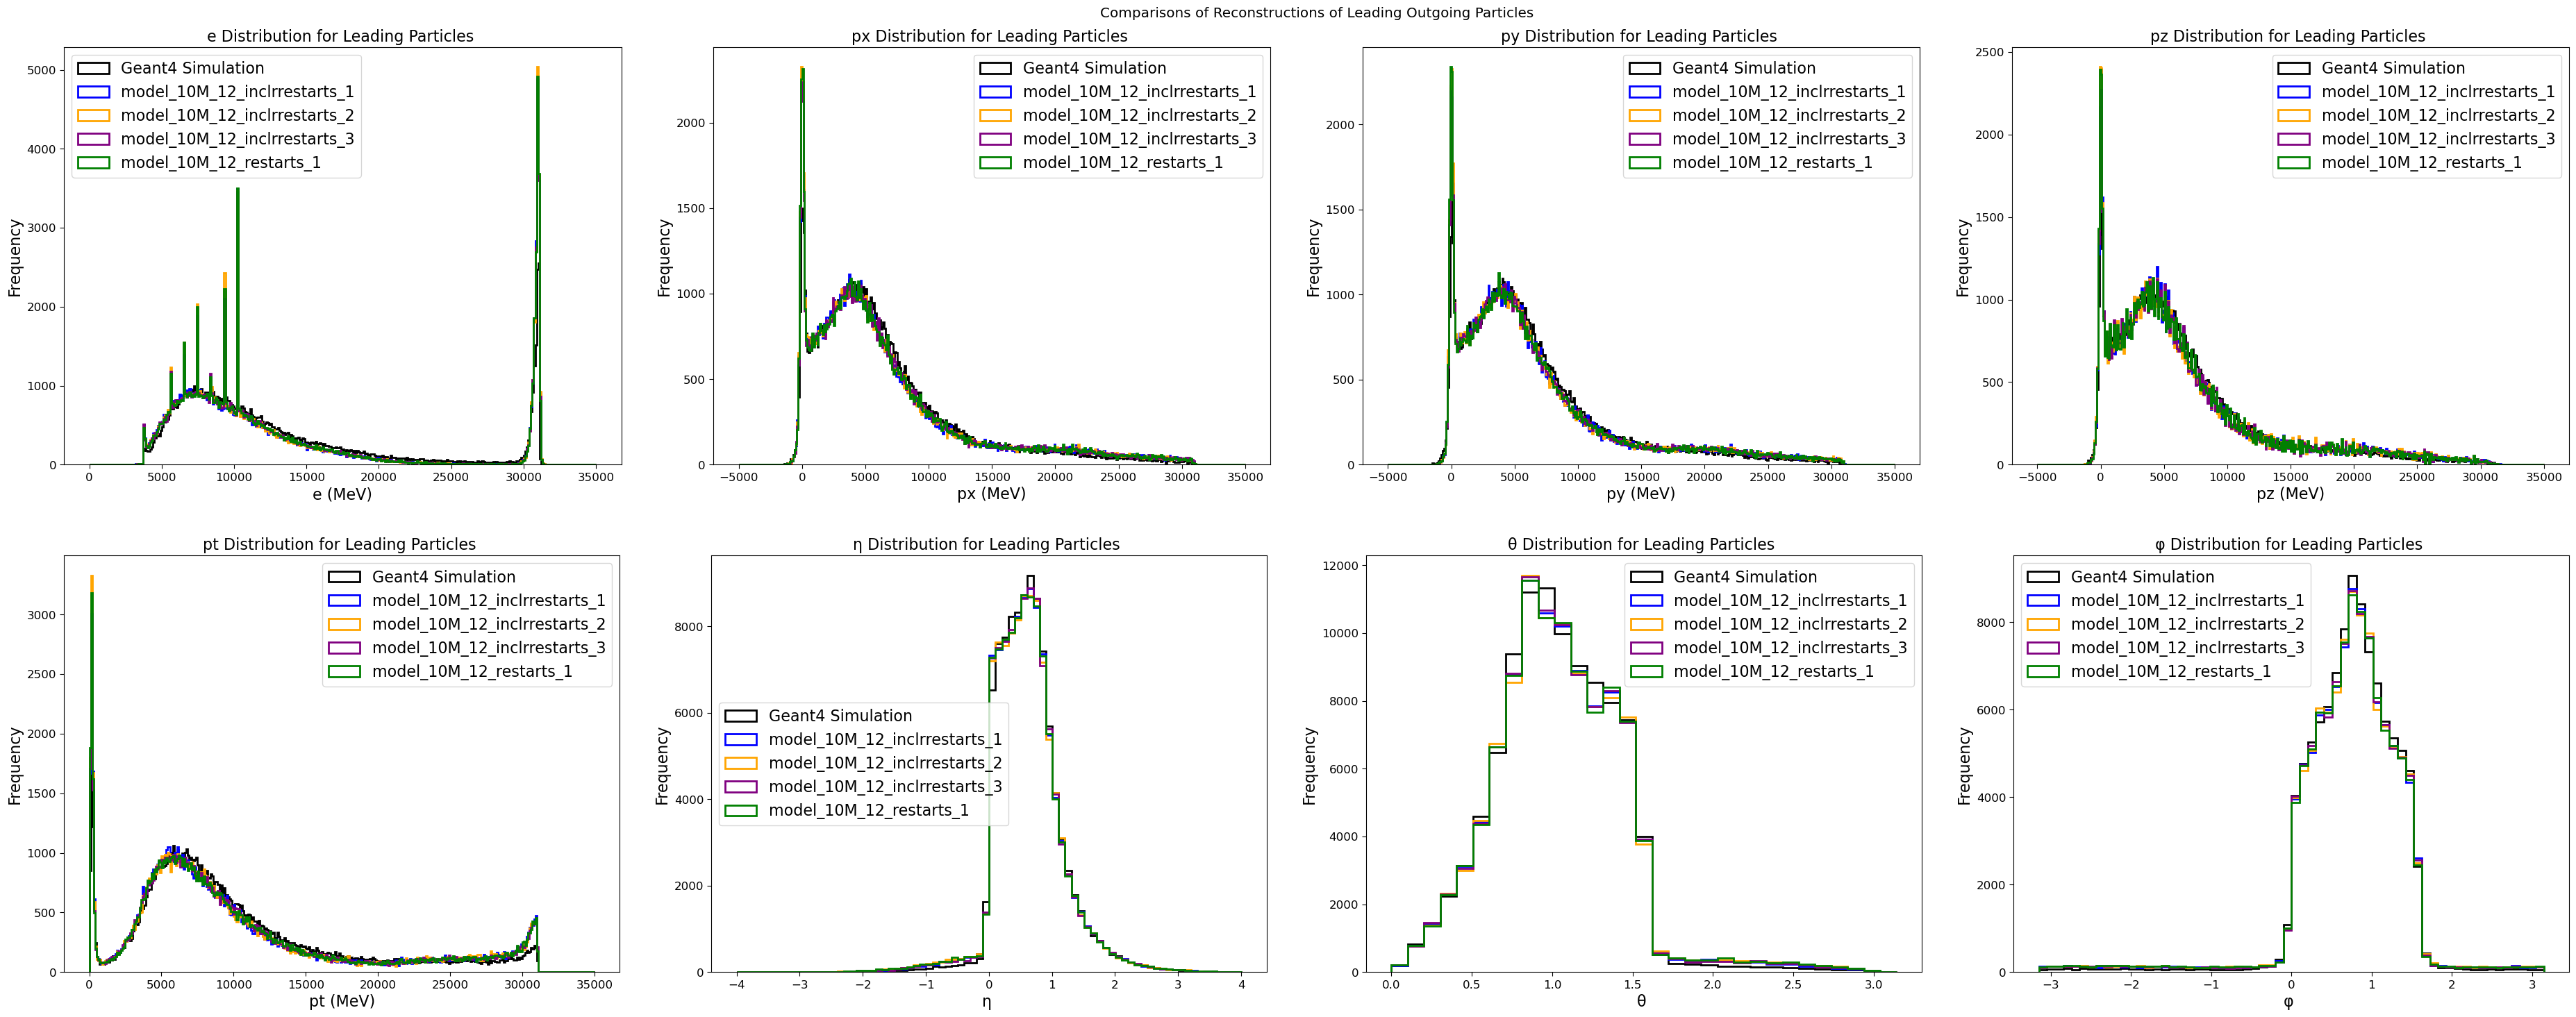

In [24]:
wall_leading = (leading_particles_bricks[0] | leading_particles_bricks[1] | leading_particles_bricks[2] | leading_particles_bricks[3]) / (leading_particles_bricks[4] | leading_particles_bricks[5] | leading_particles_bricks[6] | leading_particles_bricks[7])
wall_leading.set_suptitle('Comparisons of Reconstructions of Leading Outgoing Particles')
wall_leading.savefig()